In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

# === Thiết bị ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Config ===
img_size = 224
batch_size = 32
num_classes = 6
model_path = "D:/KLTN/FINAL_SKINTONE/mobilenetv2_best_yolov8_tuned_3.pth"
test_dir = "D:/KLTN/FINAL_SKINTONE/public/dataset_13/dataset_yolov8/test"
val_dir="D:/KLTN/FINAL_SKINTONE/public/dataset_13/dataset_yolov8/val"

# === Transform giống khi huấn luyện ===
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
# Load lại MobileNetV2 + sửa classifier
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, num_classes)
)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Tải dữ liệu test
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hàm đánh giá
def evaluate(model, loader):
    all_preds, all_labels = [], []
    criterion = nn.CrossEntropyLoss()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    acc = total_correct / len(loader.dataset)
    return avg_loss, acc, all_labels, all_preds

# Gọi hàm
test_loss, test_acc, test_labels, test_preds = evaluate(model, test_loader)
print(f" Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.9422 | Loss: 0.1513


 Classification Report:
              precision    recall  f1-score   support

      Type_1       0.97      1.00      0.99       110
      Type_2       0.95      0.84      0.89       105
      Type_3       0.82      0.89      0.86       110
      Type_4       0.92      0.93      0.93       104
      Type_5       1.00      0.98      0.99       119
      Type_6       0.99      1.00      1.00       110

    accuracy                           0.94       658
   macro avg       0.94      0.94      0.94       658
weighted avg       0.94      0.94      0.94       658



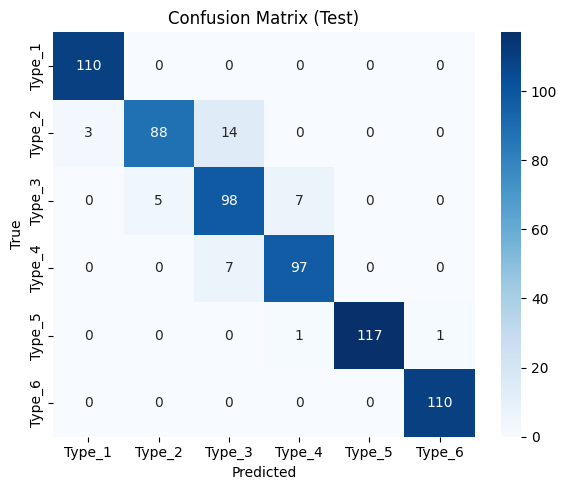

In [7]:
# Báo cáo phân loại
print(" Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

# Vẽ confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


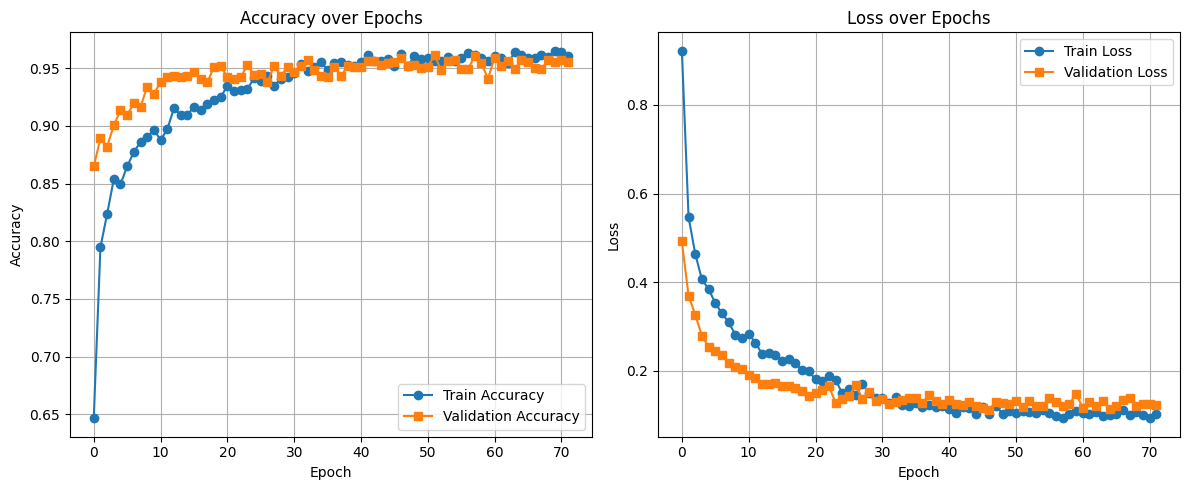

In [8]:
import json
import matplotlib.pyplot as plt

with open("D:/KLTN/FINAL_SKINTONE/mobilenetv2_best_yolov8_tuned_3.json", "r") as f:
    history = json.load(f)



plt.figure(figsize=(12, 5))

# === Accuracy ===
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# === Loss ===
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




0: 640x448 1 chin, 1 left, 1 right, 51.6ms
Speed: 5.3ms preprocess, 51.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)
🎯 Tông da dự đoán: Type_1


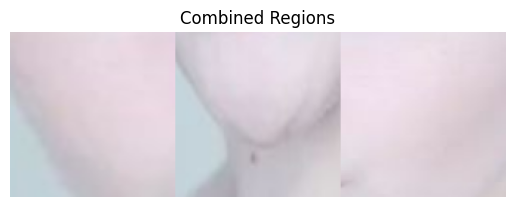

In [21]:
import torch
import cv2
import numpy as np
import os
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

# ==== CẤU HÌNH ====
yolo_model_path = "D:/KLTN/FINAL_SKINTONE/runs/detect/cheek_chin_yolov8_skin/weights/best.pt"
skin_model_path = "D:/KLTN/FINAL_SKINTONE/mobilenetv2_best_yolov8_tuned_3.pth"
image_path = "D:/KLTN/FINAL_SKINTONE/test_images2/1.jpg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 6
labels = ['Type_1', 'Type_2', 'Type_3', 'Type_4', 'Type_5', 'Type_6']

# ==== SHRINK MAP ====
shrink_ratio_map = {
    "left": 0.3,
    "right": 0.3,
    "chin": 0.1
}

# ==== LOAD YOLO MODEL ====
model_yolo = YOLO(yolo_model_path)

# ==== LOAD SKIN TONE CLASSIFIER ====
model_skin = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model_skin.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model_skin.classifier[1].in_features, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, num_classes)
)
model_skin.load_state_dict(torch.load(skin_model_path, map_location=device))
model_skin = model_skin.to(device)
model_skin.eval()

# ==== TIỀN XỬ LÝ ====
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

# ==== TRÍCH XUẤT VÀ CẮT VÙNG ====
def extract_shrunk_regions(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Không đọc được ảnh.")
        return None

    h_img, w_img, _ = image.shape
    results = model_yolo(image, conf=0.2)[0]
    crops = {'left': None, 'right': None, 'chin': None}
    best_boxes = {}

    for i, box in enumerate(results.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)
        conf = float(results.boxes.conf[i])
        cls_id = int(results.boxes.cls[i])
        raw_label = model_yolo.names[cls_id]
        cx = (x1 + x2) // 2

        # Gán đúng nhãn
        if raw_label in ["left", "right"]:
            label = "left" if cx < w_img // 2 else "right"
        elif raw_label == "chin":
            label = "chin"
        else:
            continue

        if label not in best_boxes or conf > best_boxes[label]["conf"]:
            best_boxes[label] = {"conf": conf, "coords": (x1, y1, x2, y2)}

    for label, box_data in best_boxes.items():
        x1, y1, x2, y2 = map(int, box_data["coords"])
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 0.05 * w_img or box_h < 0.05 * h_img:
            continue

        # Shift cằm xuống
        if label == "chin":
            chin_shift = int(0.35 * box_h)
            y1 = min(y1 + chin_shift, h_img)
            y2 = min(y2 + chin_shift, h_img)

        # Shrink
        shrink = shrink_ratio_map.get(label, 0.1)
        x1_s = max(int(x1 + shrink * box_w / 2), 0)
        y1_s = max(int(y1 + shrink * box_h / 2), 0)
        x2_s = min(int(x2 - shrink * box_w / 2), w_img)
        y2_s = min(int(y2 - shrink * box_h / 2), h_img)

        crop = image[y1_s:y2_s, x1_s:x2_s]
        if crop.shape[0] < 20 or crop.shape[1] < 20:
            continue

        crops[label] = crop

    return crops

# ==== GHÉP MÁ - CẰM - MÁ ====
def combine_regions(crops):
    tiles = []
    for region in ['left', 'chin', 'right']:
        crop = crops.get(region)
        if crop is None:
            print(f"⚠️ Thiếu vùng: {region}")
            return None
        resized = cv2.resize(crop, (112, 112))
        tiles.append(resized)

    combined = np.hstack(tiles)
    return combined

# ==== DỰ ĐOÁN ====
def predict_skin_tone(combined_image):
    img_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(img_rgb)
    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model_skin(input_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()

    return labels[predicted_class]

# ==== MAIN ====
crops = extract_shrunk_regions(image_path)
combined_image = combine_regions(crops)

if combined_image is not None:
    tone = predict_skin_tone(combined_image)
    print(f"🎯 Tông da dự đoán: {tone}")

    # Hiển thị ảnh ghép
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.title("Combined Regions")
    plt.axis('off')
    plt.show()
else:
    print("❌ Không thể ghép đủ 3 vùng.")
